# Preprocessing: Cropping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tiff
from tifffile import imsave
from tifffile import TiffWriter
from PIL import Image
import natsort
from ipywidgets import interact, interactive, fixed, interact_manual
import time

### First, read an example image file

In [9]:
# Find the data

data_folder = '/users/charles.fieseler/shared_projects/ForCharlie/27082020_freelyimmobilized_trial2/'
data_file = 'ZIM2051_trial_21_w2dual2-GFP-mCherry-SD-DV--488Ex--561Ex_t9.stk'
# data_file = 'ZIM2051_trial_11_w2dual2-GFP-mCherry-SD-DV--488Ex--561Ex_t9.stk'

full_fname = os.path.join(data_folder, data_file)


In [10]:
# Actually read the data in
im = tiff.imread(full_fname)

In [11]:
def myplt(i):
    plt.figure(figsize=[15,15])
    plt.imshow(im[i,...])
    plt.title(f"Slice {i}")
    plt.colorbar()
interact(myplt, i=(0, 33))

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

<function __main__.myplt(i)>

## Determine the crop via GUI

Uses this package:
https://openbits.app/posts/python-interactive-cropping/

pip install interactivecrop

In [12]:
from interactivecrop.interactivecrop import main as crop

In [13]:
# Use same fname as the example

data_folder = '/users/charles.fieseler/shared_projects/ForCharlie/27082020_freelyimmobilized_trial2/'
data_file = 'ZIM2051_trial_21_w2dual2-GFP-mCherry-SD-DV--488Ex--561Ex_t9.stk'
# data_file = 'ZIM2051_trial_11_w2dual2-GFP-mCherry-SD-DV--488Ex--561Ex_t9.stk'

full_fname = os.path.join(data_folder, data_file)

# Actually read the data in
im = tiff.imread(full_fname)

In [14]:
# Display only one slice
which_slice = 15

w = crop([im[which_slice,...]])
display(w)

GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

## ACTUALLY SAVE THE CROP SIZE

In [89]:
crop_sz = [w.children[1].value, w.children[2].value]
print(crop_sz)

[(276, 664), (361, 531)]


In [90]:
def crop_func(im, crop_sz):
    crop_width, crop_height = crop_sz
    nz, n_height, n_width = im.shape
#     crop_height = 
    return im[:,n_height-crop_height[1]:n_height-crop_height[0], crop_width[0]:crop_width[1]]

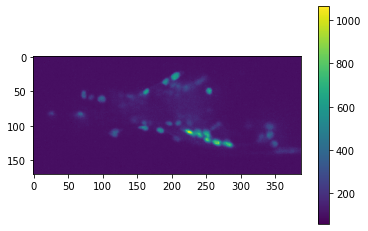

In [91]:
# Show an example frame actually cropped
plt.imshow(crop_func(im, crop_sz)[which_slice,...])
plt.colorbar()

In [99]:
print(f'Original shape: {im.shape}')
print(f'New shape: {crop_func(im, crop_sz).shape}')

Original shape (33, 655, 885)
New shape (33, 170, 388)


## Using the crop sizes, save as ome.tiff

In [2]:
data_parent_folder = '/users/charles.fieseler/shared_projects/ForCharlie/'
data_folder = '27082020_freelyimmobilized_trial2'

# Input
input_folder = os.path.join(data_parent_folder, data_folder)

# New, output folder
o_name = 'ome_tiff'
output_folder = os.path.normpath(os.path.join(data_parent_folder, data_folder, '..', f'{data_folder}_{o_name}_{int(time.time())}'))

##select z slices to save (only works on axis=0)
# fri=0
# frf=33

In [110]:


if not os.path.exists(output_folder):
    os.makedirs(output_folder)
else:
    print(f"Folder {output_folder} already exists!")
filename=os.path.splitext(os.listdir(input_folder)[0])[0]
print('Reading all files in directory {}'.format(filename))
# IM=tiff.imread(os.path.join(i_directory,filename))
#fold increase for better visuTiffWriteron of the very 'short' z axis. Set to 1 for no increase.
#set it to have the same pixel size as XY (0.3um vs 1um zstep size)
# fold_increase=3


# #creates an empty matrix for the lower right part of the image. It should have the dimensions of Z-stacks times the fold increase. (now 150)
# corner_matrix=np.full((fold_increase*IM.shape[0],fold_increase*IM.shape[0]),100, dtype='uint16')

Reading all files in directory ZIM2051_trial_21


In [111]:

# Setup
final_sz = crop_func(im, crop_sz).shape

do_crop = True
if do_crop:
    print("Saving files with crop: ", crop_sz)
    print("And final shape: ", final_sz)
else:
    print("Saving files with no crop")

sorted_fnames = natsort.natsorted(os.listdir(input_folder))

Saving files with crop:  [(276, 664), (361, 531)]
And final shape:  (33, 170, 388)


In [112]:
# Finally, actually import
# Note: name the ome_tif using the metadata file from the .stk folder, i.e. the .nd file

# Note: This saves via concatenation

with TiffWriter(os.path.join(output_folder,filename+'.tif'), bigtiff=True) as tif_w:
    for i, this_file in enumerate(sorted_fnames):
        if i % 10 == 0:
            print(f'Reading file {i}/{len(sorted_fnames)}')
#         if i > 13:
#             break
        if this_file.endswith(".stk"):
            this_full_fname = os.path.join(input_folder, this_file)
            IM = tiff.imread(this_full_fname)
            # TODO: tiff.ome to get metadata
#             ome_xml_Metadata = tiff.TiffFile(this_full_fname).ome_metadata
#             print(ome_xml_Metadata)
            
            # Note: shape is zhw
            if do_crop:
                final_image = IM[:,crop_height[0]:crop_height[1], crop_width[0]:crop_width[1]]
            else:
                final_image = IM

            # convert to 16bit
            #final_image16bit = np.int16(final_image)

            # data = numpy.random.randint(0, 255, (5, 2, 3, 301, 219), 'uint8')
            
            # TODO: implement a basic buffer
            tif_w.save(final_image, compress=0, photometric='minisblack')
#             tif_w.save(final_image, compress=0, photometric='minisblack', contiguous=True)
#             clear_output()
print('end')

Reading file 0/9092


NameError: name 'crop_height' is not defined

In [113]:
# Finally, actually import
# Note: name the ome_tif using the metadata file from the .stk folder, i.e. the .nd file

# Note: This saves via buffering, i.e. by reading into memory

final_data = np.empty( ((len(sorted_fnames),) + final_sz) )

for i, this_file in enumerate(sorted_fnames):
    if i % 10 == 0:
        print(f'Reading file {i}/{len(sorted_fnames)}')
    if this_file.endswith(".stk"):
        this_full_fname = os.path.join(input_folder, this_file)
        IM = tiff.imread(this_full_fname)

        # Note: shape is zhw
        if do_crop:
            final_image = crop_func(IM, crop_sz)
        else:
            final_image = IM

        final_data[i,...] = final_image
        
# Finally, write the big array
print("Writing the entire file...")
with TiffWriter(os.path.join(output_folder,filename+'.tif'), bigtiff=True) as tif_w:
    tif_w.save(final_data, compress=0, photometric='minisblack')
    
print('end')

Reading file 0/9092
Reading file 10/9092
Reading file 20/9092
Reading file 30/9092
Reading file 40/9092
Reading file 50/9092
Reading file 60/9092
Reading file 70/9092
Reading file 80/9092
Reading file 90/9092
Reading file 100/9092
Reading file 110/9092
Reading file 120/9092
Reading file 130/9092
Reading file 140/9092
Reading file 150/9092
Reading file 160/9092
Reading file 170/9092
Reading file 180/9092
Reading file 190/9092
Reading file 200/9092
Reading file 210/9092
Reading file 220/9092
Reading file 230/9092
Reading file 240/9092
Reading file 250/9092
Reading file 260/9092
Reading file 270/9092
Reading file 280/9092
Reading file 290/9092
Reading file 300/9092
Reading file 310/9092
Reading file 320/9092
Reading file 330/9092
Reading file 340/9092
Reading file 350/9092
Reading file 360/9092
Reading file 370/9092
Reading file 380/9092
Reading file 390/9092
Reading file 400/9092
Reading file 410/9092
Reading file 420/9092
Reading file 430/9092
Reading file 440/9092
Reading file 450/9092

# Reading the ome.tiff file back in to check

In [2]:
import tifffile
import os
from DLC_for_WBFM.utils.video_and_data_conversion.xml_utils import *
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual


In [10]:
#pathtofile
data_parent_folder = '/users/charles.fieseler/shared_projects/ForCharlie/'
data_folder = '27082020_freelyimmobilized_trial2_ome_tiff_1601990420' # NOTE: these folders are time stamped
data_file = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21.tif')

# Input
tmp = []
with tifffile.TiffFile(data_file, multifile=False) as tif:
#     tmp = tif.pages[0].shape
    print(tif.series[0])
#     print(tif.pages[0].__dict__)
#     im = tif.asarray()
#     omexmlMetadataString = tif.ome_metadata
# print(tmp)

TiffPageSeries 0  9092x33x170x388  float64  QQYX  Shaped  300036 Pages  Offset=512


In [11]:
tif = tifffile.TiffFile(data_file, multifile=False)

In [14]:
def myplt(i_z, i_t):
    nz = 33
    vol_indices = list(range(i_t*nz, i_t*nz + nz))
    im = tifffile.imread(data_file, key=vol_indices)
    plt.figure(figsize=[15,15])
    plt.imshow(im[i_z,...])
    plt.title(f"Frame {i_t}")
    plt.colorbar()
interact(myplt, i_z=(0, 33), i_t=(0,100))

interactive(children=(IntSlider(value=16, description='i_z', max=33), IntSlider(value=50, description='i_t'), …

<function __main__.myplt(i_z, i_t)>

# Scratch: adding metadata from stk


In [1]:
import tifffile
import os

### An example of correct metadata
As converted by fiji

In [8]:

#pathtofile
filePath = '/groups/zimmer/Itamar/wbimaing_datasets/18092020/control/w3/Head_Converted/nlp12CRE_Parrd16DO_strain1_ctrl_w3_VI_LU_HEAD.ome.tif'
with tifffile.TiffFile(filePath, multifile=False) as tif:
#     orgImg = tif.asarray()
    omexmlMetadataString = tif.ome_metadata

In [12]:
print(type(omexmlMetadataString))
omexmlMetadataString.encode("utf-8")

<class 'dict'>


AttributeError: 'dict' object has no attribute 'encode'

In [3]:
omexmlMetadataString.keys()
# Only 'Image' really matters

dict_keys(['Instrument', 'Image', 'Creator', 'UUID', '{http://www.w3.org/2001/XMLSchema-instance}schemaLocation'])

In [28]:
omexmlMetadataString['Image']['Pixels'].keys()

dict_keys(['Channel', 'TiffData', 'Plane', 'BigEndian', 'DimensionOrder', 'ID', 'Interleaved', 'PhysicalSizeX', 'PhysicalSizeXUnit', 'PhysicalSizeY', 'PhysicalSizeYUnit', 'PhysicalSizeZ', 'PhysicalSizeZUnit', 'SignificantBits', 'SizeC', 'SizeT', 'SizeX', 'SizeY', 'SizeZ', 'TimeIncrement', 'TimeIncrementUnit', 'Type'])

In [82]:
omexmlMetadataString['Image']['Pixels']['Type']

'uint16'

In [64]:
omexmlMetadataString['Image']['Pixels']['DimensionOrder']

'XYCZT'

In [4]:
orgImg.shape

(3600, 15, 115, 505)

### Look at the metadata of an original stk file
Note that I might just write the metadata de novo instead of copying

In [61]:

# First, read one of the original .stk files
data_parent_folder = '/users/charles.fieseler/shared_projects/ForCharlie/'
data_folder = '27082020_freelyimmobilized_trial2'
# data_file = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21.nd')
data_file = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21_w2dual2-GFP-mCherry-SD-DV--488Ex--561Ex_t2365.stk')

stk_dat = tifffile.TiffFile(data_file, multifile=False)

In [85]:
# print(stk_dat.asarray().shape)
stk_dat.stk_metadata.keys()
# print(stk_dat.)

dict_keys(['NumberPlanes', 'PlaneDescriptions', 'SpatialCalibration', 'XCalibration', 'YCalibration', 'CalibrationUnits', 'CreateTime', 'LastSavedTime', 'StandardLUT', 'wavelength', 'CameraBin', 'NewLUT', 'PlaneProperty', 'Wavelengths', 'StagePosition', 'StageLabel', 'MinScale', 'ZDistance', 'TimeCreated', 'TimeModified', 'DatetimeCreated', 'DatetimeModified'])

### Test with my new function

In [1]:
from DLC_for_WBFM.utils.video_and_data_conversion.stk_to_ome_utils import *
from DLC_for_WBFM.utils.video_and_data_conversion.xml_utils import *

import os

In [2]:
# Read in the ome-tiff, which will be overwritten at the end
data_parent_folder = '/users/charles.fieseler/shared_projects/ForCharlie/'
data_folder = '27082020_freelyimmobilized_trial2_ome_tiff_1601990420' # NOTE: these folders are time stamped
ome_data_file = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21_metadata_test.tif')

with tifffile.TiffFile(ome_data_file, multifile=False) as tif:
    tmp = tif.series[0].shape
    dat_sz = tmp # Keep as original shape
#     print(tif.imagej_metadata)
    print(dat_sz)
#     dat_sz = [tmp[2], tmp[3], 3, tmp[1], tmp[0]] # Translate to XYCZT

(9092, 33, 170, 388)


In [3]:
data_parent_folder = '/users/charles.fieseler/shared_projects/ForCharlie/'
data_folder = '27082020_freelyimmobilized_trial2'
# data_file = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21.nd')
stk_file = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21_w2dual2-GFP-mCherry-SD-DV--488Ex--561Ex_t2365.stk')

# dat_sz = (170, 388, 3, 33, 5400)

new_metadata = ome_metadata_from_array_and_stk(stk_file, dat_sz)

dict_pretty_print(new_metadata)

Instrument
	
Image
	Pixels
		SizeZ
			33
		PhysicalSizeX
			6.45
		PhysicalSizeY
			6.45
		PhysicalSizeXUnit
			um
		PhysicalSizeYUnit
			um
		PhysicalSizeZUnit
			um
		SizeX
			170
		SizeY
			388
		SizeT
			9092
		Type
			uint16
Creator
	
UUID
	


In [4]:

with tifffile.TiffFile(ome_data_file, multifile=False) as tif:
    print("Reading...")
    original_dat = tif.asarray()

Reading...


In [5]:
original_dat.shape

(9092, 33, 170, 388)

In [13]:
new_fname = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21_metadata_test.ome.tiff')

print("Writing...")
tifffile.imsave(new_fname,original_dat,metadata=new_metadata, photometric='minisblack',bigtiff=True)
print("Done")

Writing...
Done


In [ ]:
new_fname = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21_metadata_test.ome.tiff')

with tifffile.TiffWriter(new_fname, bigtiff=True) as tif:
    tif.save(original_dat, metadata=new_metadata, photometric='minisblack') # NOTE: this function will be deprecated

In [ ]:
# CHECK
tif = tifffile.TiffFile(new_fname, multifile=False)

In [ ]:
tif.metadata

In [20]:
tif.shaped_metadata

({'Instrument': '',
  'Image': {'Pixels': {'SizeZ': 33,
    'PhysicalSizeX': 6.45,
    'PhysicalSizeY': 6.45,
    'PhysicalSizeXUnit': 'um',
    'PhysicalSizeYUnit': 'um',
    'PhysicalSizeZUnit': 'um',
    'SizeX': 170,
    'SizeY': 388,
    'SizeT': 9092,
    'Type': 'uint16'}},
  'Creator': '',
  'UUID': '',
  'shape': [9092, 33, 170, 388]},)

### Test metadata production with apeer-ometiff

In [11]:
from DLC_for_WBFM.utils.video_and_data_conversion.stk_to_ome_utils import *
from DLC_for_WBFM.utils.video_and_data_conversion.xml_utils import *

import apeer_ometiff_library.io as io
import os

In [4]:
# Read in the ome-tiff, which will be overwritten at the end
data_parent_folder = '/users/charles.fieseler/shared_projects/ForCharlie/'
data_folder = '27082020_freelyimmobilized_trial2_ome_tiff_1601990420' # NOTE: these folders are time stamped
ome_data_file = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21_metadata_test.tif')


with tifffile.TiffFile(ome_data_file, multifile=False) as tif:
    print("Reading...")
    original_dat = tif.asarray()

Reading...


In [32]:
original_dat.shape

(9092, 33, 170, 388)

In [35]:
original_dat_expanded = np.expand_dims(original_dat, axis=2) # Add  c, to make it TZCXY

data_parent_folder = '/users/charles.fieseler/shared_projects/ForCharlie/'
data_folder = '27082020_freelyimmobilized_trial2_ome_tiff_1601990420' # NOTE: these folders are time stamped
out_ome_data_file = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21_metadata_test.ome.tiff')

io.write_ometiff(out_ome_data_file, original_dat_expanded) # TEST: few frames

### Smaller data file

In [14]:

data_parent_folder = '/users/charles.fieseler/shared_projects/wbfm/dat/immobilized_wbfm_hardware/'
data_file = 'ZIM2051_trial_21.ome.tiff'
ome_data_file = os.path.join(data_parent_folder, data_file)

with tifffile.TiffFile(ome_data_file, multifile=False) as tif:
    print("Reading...")
    small_dat = tif.asarray()

Reading...


In [31]:
small_dat_expanded = np.expand_dims(small_dat, axis=[1,2]) # Add z and c, both null dimensions

out_ome_data_file = os.path.join(data_parent_folder, 'ZIM2051_trial_21_apeer_metadata.ome.tiff')

io.write_ometiff(out_ome_data_file, small_dat_expanded)

# Save a video for DLC (single plane)

In [1]:
from DLC_for_WBFM.utils.video_and_data_conversion.video_conversion_utils import *
import tifffile
import os

In [2]:
# Locations of input and output
data_parent_folder = '/users/charles.fieseler/shared_projects/ForCharlie/'
data_folder = '27082020_freelyimmobilized_trial2_ome_tiff_1601990420'
input_fname = os.path.join(data_parent_folder, data_folder, 'ZIM2051_trial_21.tif')

target_folder = '/users/charles.fieseler/dat/'
output_fname = os.path.join(target_folder, 'ZIM2051_trial_21.ome.tiff')

In [3]:
# Settings
which_slice = 15
num_frames = 1000

In [4]:
# Creates a smaller ome.tiff file with only these frames and slice
dat = write_video_from_ome_file(num_frames, input_fname, output_fname, which_slice=which_slice, out_dtype='uint32')

Read volume 0/1000
Final shape should be:  [1000, 170, 388]
Read volume 10/1000
Read volume 20/1000
Read volume 30/1000
Read volume 40/1000
Read volume 50/1000
Read volume 60/1000
Read volume 70/1000
Read volume 80/1000
Read volume 90/1000
Read volume 100/1000
Read volume 110/1000
Read volume 120/1000
Read volume 130/1000
Read volume 140/1000
Read volume 150/1000
Read volume 160/1000
Read volume 170/1000
Read volume 180/1000
Read volume 190/1000
Read volume 200/1000
Read volume 210/1000
Read volume 220/1000
Read volume 230/1000
Read volume 240/1000
Read volume 250/1000
Read volume 260/1000
Read volume 270/1000
Read volume 280/1000
Read volume 290/1000
Read volume 300/1000
Read volume 310/1000
Read volume 320/1000
Read volume 330/1000
Read volume 340/1000
Read volume 350/1000
Read volume 360/1000
Read volume 370/1000
Read volume 380/1000
Read volume 390/1000
Read volume 400/1000
Read volume 410/1000
Read volume 420/1000
Read volume 430/1000
Read volume 440/1000
Read volume 450/1000
Read

In [5]:
# Creates the DLC-compatible video
write_numpy_as_avi(dat, fname=output_fname) # from above OME-TIFF

Writing to /users/charles.fieseler/dat/ZIM2051_trial_21.ome.tiff.avi
Writing frame 0/1000
Writing frame 10/1000
Writing frame 20/1000
Writing frame 30/1000
Writing frame 40/1000
Writing frame 50/1000
Writing frame 60/1000
Writing frame 70/1000
Writing frame 80/1000
Writing frame 90/1000
Writing frame 100/1000
Writing frame 110/1000
Writing frame 120/1000
Writing frame 130/1000
Writing frame 140/1000
Writing frame 150/1000
Writing frame 160/1000
Writing frame 170/1000
Writing frame 180/1000
Writing frame 190/1000
Writing frame 200/1000
Writing frame 210/1000
Writing frame 220/1000
Writing frame 230/1000
Writing frame 240/1000
Writing frame 250/1000
Writing frame 260/1000
Writing frame 270/1000
Writing frame 280/1000
Writing frame 290/1000
Writing frame 300/1000
Writing frame 310/1000
Writing frame 320/1000
Writing frame 330/1000
Writing frame 340/1000
Writing frame 350/1000
Writing frame 360/1000
Writing frame 370/1000
Writing frame 380/1000
Writing frame 390/1000
Writing frame 400/1000